In [1]:
!nvidia-smi

Wed Sep  4 14:16:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   46C    P5             15W /   80W |     731MiB /   6144MiB |     74%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import random
import torch.nn as nn
import torch
import pickle as pkl
import pandas as pd
import time
from collections import defaultdict
import logging

logging.basicConfig(level=logging.INFO)

# Load the modules:
from normalize import Normalization
from model import lstm_encoder, lstm_decoder, lstm_seq2seq, EnsembleModel, xavier_initialize, he_initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
print(torch.__version__)

2.3.1


In [5]:
PATH = r'/home/anshul/Research/Pred_unc_aware_planning/Deep_Ensemble/Trained_models'
# with open(os.path.join(PATH, 'weights.pkl'), 'rb') as f:
#     weights = pkl.load(f)

'''
Why test_df.pkl and not test_data.pkl is used?
'''
with open (os.path.join(PATH, 'test_df.pkl'),'rb') as f:
    [test_df, test_agents] = pkl.load(f)


In [6]:
def create_dataset(df, agents, look_back = 8, forward_pred = 12, skip=2, device = device):
    traj_test_input = {}
    traj_test_output = {}
    initial_pos = {}
    
    for agent_id in agents:
        sub_df = df[df['agent_id'] == agent_id]
        data_x, data_y, data_frames = [], [], []
        start_pos = []
        
        for j in range(0, len(sub_df)-look_back-forward_pred+1, skip):
            pos_lb = sub_df.iloc[j:j+look_back][['pos_x','pos_y']] -\
                        sub_df.iloc[j+look_back-1][['pos_x','pos_y']] 
            vel_lb = sub_df.iloc[j:j+look_back][['vel_x','vel_y']]
            
            data_x.append(pd.concat([pos_lb,vel_lb], axis=1).values)

            


            pos_fp = sub_df.iloc[j+look_back:j+forward_pred+look_back][['pos_x','pos_y']] -\
                        sub_df.iloc[j+look_back-1][['pos_x','pos_y']] 
            vel_fp = sub_df.iloc[j+look_back:j+forward_pred+look_back][['vel_x','vel_y']]
            data_y.append(pd.concat([pos_fp,vel_fp], axis=1).values)
            
            start_pos.append(sub_df.iloc[j+look_back-1][['pos_x','pos_y']])
            data_frames.append(sub_df.iloc)
        
        data_x = np.array(data_x)
        data_y = np.array(data_y)
        start_pos = np.array(start_pos)
        
        traj_test_input[agent_id] = torch.tensor(data_x, dtype=torch.float).to(device)
        traj_test_output[agent_id] = torch.tensor(data_y, dtype=torch.float).to(device)
        initial_pos[agent_id] = torch.tensor(start_pos,dtype=torch.float).to(device)
    return traj_test_input, traj_test_output, initial_pos
        

In [7]:
# test_x, test_y = create_dataset(test_df, test_agents, skip=2)
look_back = 8
forward_pred= 12
input_traj, output_traj, starting_pos = create_dataset(test_df, test_agents, look_back = look_back, forward_pred = forward_pred, skip=1, device = device)

In [11]:
input_traj[5276][5,:,:]

tensor([[-4.4939, -0.7272,  1.6682,  0.4315],
        [-3.8045, -0.5347,  1.6364,  0.3689],
        [-3.1848, -0.4321,  1.5948,  0.1957],
        [-2.5287, -0.3781,  1.6305,  0.1886],
        [-1.8804, -0.2812,  1.6033,  0.1860],
        [-1.2460, -0.2294,  1.5764,  0.1824],
        [-0.6192, -0.1353,  1.5576,  0.2867],
        [ 0.0000,  0.0000,  1.5854,  0.2259]], device='cuda:0')

In [9]:
with open(os.path.join(PATH, 'test_data.pkl'), 'rb') as f:
    [test_input, test_output, gaussian_test_traj] = pkl.load(f)

In [10]:
test_input.shape 

torch.Size([472, 3, 8, 4])

In [11]:
# first_key = next(iter(test_traj_list.keys()))

# value = test_traj_list[first_key]
# batch, seq, num_fea = value.shape

# test_input, test_output = [], []
# for id in range(batch):
#     test_x, test_y = np.split(np.squeeze(value[id, : , :]), [8], axis =0)
#     test_input.append(test_x)
#     test_output.append(test_y)

# test_input = np.array(test_input)
# test_output = np.array(test_output)
    


In [12]:
with open("./Trained_models/model_hyperparams.pkl", 'rb') as f:
    params = pkl.load(f)

params

{'dropout': 0.43,
 'learning_rate': 0.008,
 'hidden_size': 64,
 'batch_size': 64,
 'teacher_forcing_ratio': 0.88,
 'optimizer_name': 'Adam',
 'dynamic_TF': False,
 'input_size': 4,
 'output_size': 6,
 'num_layers': 2,
 'num_models': 3,
 'weight_init': <function model.xavier_initialize(model)>}

In [13]:
'''
Hint: Directly using the ensemble model for prediction rather than calling the individual models within the ensemble during 
inference as loading individual model adds additional cost. Also, ensure to get rid of for loops. Why the saved dict of 
the ensemble model did not work?
'''
# batch_size = 64
# hidden_size = 128
# dropout = 0.2
# num_fea = 4
# output_size = num_fea + 2
# num_layers = 2

with open("./Trained_models/model_hyperparams.pkl", 'rb') as f:
    params = pkl.load(f)

input_size = params['input_size']
hidden_size = params['hidden_size']
output_size = params['output_size']
num_layers = params['num_layers']
dropout = params['dropout']
num_fea = params['input_size']

final_pred = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deep_ensemble = EnsembleModel(input_size = num_fea, hidden_size = hidden_size, output_size=output_size, num_layers=num_layers,
                              dropout=dropout, use_attention=False, device = device, num_models=3, init_weight = xavier_initialize)
model_path = f"ensemble_model.pth"
deep_ensemble.load_state_dict(torch.load(os.path.join(PATH, model_path)), strict = True)
deep_ensemble.eval()
start_time = time.time()
for key, value in input_traj.items():
    with torch.no_grad():
        predictions = deep_ensemble.predict(value, target_len=forward_pred, device=device) 
        final_pred[key] = predictions
print("Total time Elapsed: {}".format(time.time() - start_time))


Total time Elapsed: 0.2697606086730957


In [14]:
with open("./Trained_models/model_hyperparams.pkl",'rb') as f:
    params = pkl.load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deep_ensemble = EnsembleModel(input_size = num_fea, hidden_size = hidden_size, output_size=output_size, num_layers=num_layers,
                              dropout=dropout, use_attention=False, device = device, num_models=3, init_weight = xavier_initialize)
ensemble_predictions = defaultdict(list)
num_models = 3

start_time = time.time()
for idx, model in enumerate(deep_ensemble.models):
    model_path = f"model_{idx}_parameters.pth"
    model.load_state_dict(torch.load(os.path.join(PATH, model_path)), strict=True)
    model.eval()

    # Temporarily storing predictions for this model
    model_predictions = {}
    for key, value in input_traj.items():
        with torch.no_grad():
            if value.shape[0] == 0:
                model_predictions[key] = np.array([])
            else:
                prediction = model.predict(value, target_len=forward_pred, device=device)
                model_predictions[key] = prediction

    # Append each key's prediction to the ensemble_predictions
    for key, preds in model_predictions.items():
        ensemble_predictions[key].append(preds)

# Transform  ensemble_predictions to numpy arrays: [3, n_traj, 12, 6]
mu_preds = {}
sigma_preds = {}
for key in ensemble_predictions:
    min_logvar, max_logvar = -4, 4
    ensemble_predictions[key] = torch.stack(ensemble_predictions[key], axis=0)
    preds = torch.cat((ensemble_predictions[key][:,:,:,:int(num_fea/2)], torch.exp(ensemble_predictions[key][:,:,:,int(num_fea/2):int(num_fea)])),3)
    sigmas = ensemble_predictions[key][:,:,:,int(num_fea):]
    sigmas = torch.clamp(sigmas, min=min_logvar, max=max_logvar)
    mu_preds[key] = torch.Tensor(preds)
    # mu_preds = denormalize_data(mu_preds, train_mean,  train_std)
    sigma_preds[key] = torch.Tensor(torch.exp(sigmas))

# Computation Time:
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# Optionally, convert the defaultdict back to a regular dict if needed
ensemble_predictions = dict(ensemble_predictions)


Elapsed time: 0.24814677238464355 seconds


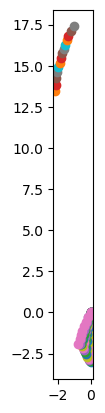

In [15]:
for i in range(input_traj[key].shape[0]):
    plt.scatter(input_traj[key][i,:,0].detach().cpu().numpy(), input_traj[key][i,:,1].detach().cpu().numpy())
    plt.scatter(starting_pos[key][i,0].detach().cpu().numpy(), starting_pos[key][i,1].detach().cpu().numpy())
ax = plt.gca()
ax.set_aspect('equal')

In [16]:
# Sigmoid function:
def sigmoid(list_x):
    return [1/(1+np.exp(-x)) for x in list_x]

# Inverse Function:
def inverse(list_x):
    return [1/(1e-4 + x) for x in list_x]

# relative loss:
def rel_loss(list_x):
    max_x = max(list_x)
    return [(max_x-x) for x in list_x]


# Weights:
def weights_(list_x):
    return [x/sum(list_x) for x in list_x] 

# Weighted sum:
def weighted_sum(weights, array):
#     mu_ens = np.zeors_like(mu_preds[0])
    avg_ens = np.tensordot(weights, array, axes=([0], [0]))
    return avg_ens
        

In [17]:
# Compute the ensemble mean and variance:
# mu_preds, sigma_preds =torch.stack(preds), torch.stack(sigmas) # Imp to convert a torch list to tensor

import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse

def plot_UQ(X_test, y_test, mus, sigmas, weights, id_no=100):
    
    num_fea = mus.shape[3]
#     sigmas = np.exp(sigmas)
    mu_preds = mus
    fig, axs = plt.subplots(nrows = 4, ncols =1, figsize =(12, 12), sharex= True, sharey=False)
    for n_ens in range(mu_preds.shape[0]):

        axs[n_ens].scatter(X_test[id_no,:,0],  X_test[id_no,:,1], color='g',marker='o',s =5, label = 'Input')
        axs[n_ens].plot(y_test[id_no,:,0],  y_test[id_no,:,1], color='r',alpha=0.5, marker='^', ms =3,label = 'Ground Truth' )
        axs[n_ens].plot(mu_preds[n_ens,id_no,:,0], mu_preds[n_ens,id_no,:,1], color='b', marker='d', alpha=0.85, ms = 3, label = 'NN state Estimate' )

        num_fea = mu_preds.shape[3]
        var_state_unc = (mu_preds[n_ens,:,:,2:4]) 

        state_cov = []
        pred_cov = []
        mu = []
        for pred in range(forward_pred): 

            mean = np.squeeze(mu_preds[n_ens,id_no, pred, :])
            cov_pred = np.squeeze(np.diag(sigmas[n_ens,id_no,pred,:]))

            cov_state = np.squeeze(var_state_unc[id_no, pred,:2])
            cov_state = np.diag(np.squeeze(cov_state))

            lambda_tot, v_tot = np.linalg.eig(cov_pred)
            lambda_tot = np.sqrt(lambda_tot)

            lambda_ale, v_ale = np.linalg.eig(cov_state)
            lambda_ale = np.sqrt(lambda_ale)

    #         for pred in range(20):
    #             cov = np.cov(ground_cov[:,id_no,pred,0],ground_cov[:,id_no,pred,1] ) 
    #             lambda_, v_ = np.linalg.eig(cov)
    #             lambda_ = np.sqrt(lambda_)


    #             for j in range(2,3):
    #                 ell3 = Ellipse(xy = (ground_cov[:,id_no,pred,0].mean(), ground_cov[:,id_no,pred,1].mean()),
    #                          width = (lambda_[0] ) * j* 2 ,
    #                          height = (lambda_[1] ) *j* 2,
    #                             angle = np.degrees(np.arctan2(v_[1, 0], v_[0, 0])),
    #                              color = 'black',  lw = 0.5) 
    #                 ell3.set_facecolor('green')
    #                 ell3.set_alpha(0.25)
    #                 ax.add_artist(ell3)
    #             ell3.set_label("KF state uncertainty $(2\sigma)$")


            for j in range(1,2):
                ell1 = Ellipse(xy = (mean[0], mean[1]),
                         width = ( 1* lambda_ale[0] ) * j* 2 ,
                         height = ( 1*lambda_ale[1] ) *j* 2,
                            angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                             color = 'none',  lw = 0.5) 
                ell1.set_facecolor('tab:blue')
                ell1.set_alpha(0.2/j)
                axs[n_ens].add_artist(ell1)

                ell2 = Ellipse(xy = (mean[0], mean[1]),
                     width = (lambda_tot[0]) * j* 2,
                     height = (lambda_tot[1]) *j* 2,
                        angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                     color = 'none', linestyle  ='--', lw = 0.25)
                ell2.set_facecolor('tab:olive')
                ell2.set_alpha(0.4/j)
                axs[n_ens].add_artist(ell2)

        axs[n_ens].set_ylim([-12,12])
        axs[n_ens].set_xlim([-12,12])
        axs[n_ens].set_aspect('equal', adjustable='box')

    # Ensemble model Average:
    mu_ens = weighted_sum(weights, mu_preds) 
    axs[3].scatter(X_test[id_no,:,0],  X_test[id_no,:,1], color='g',marker='o',s =5, label = 'Input')
    axs[3].plot(y_test[id_no,:,0],  y_test[id_no,:,1], color='r',alpha=0.5, marker='^', ms =3,label = 'Ground Truth' )
    axs[3].plot(mu_ens[id_no,:,0], mu_ens[id_no,:,1], color='b', marker='d', alpha=0.85, ms = 3, label = 'NN state Estimate' )
    axs[3].set_ylim([-12,12])
    axs[3].set_xlim([-12,12])
    axs[3].set_aspect('equal', adjustable='box')

    var_aleatoric = weighted_sum(weights, sigmas[:,:,:,:2])
    var_epistemic = weighted_sum(weights, mu_preds[:,:,:,:2]**2) - mu_ens[:,:,:2]**2
    var_ens = var_aleatoric  + var_epistemic

    var_state_unc = (weighted_sum(weights, mu_preds[:,:,:,2:4])) 
#     print(var_state_unc)

    for pred in range(forward_pred): 

            mean = np.squeeze(mu_ens[id_no, pred, :])
            cov_pred = np.squeeze(np.squeeze(np.diag(var_ens[id_no,pred,:])))

            # Total Variance:
            cov_state = np.squeeze(var_state_unc[id_no, pred,:2])
            cov_state = np.diag(np.squeeze(cov_state))


            lambda_tot, v_tot = np.linalg.eig(cov_pred)
            lambda_tot = np.sqrt(lambda_tot)

            lambda_ale, v_ale = np.linalg.eig(cov_state)
            lambda_ale = np.sqrt(lambda_ale)


            for j in range(1,2):
                ell1 = Ellipse(xy = (mean[0], mean[1]),
                         width = ( 1* lambda_ale[0] ) * j* 2 ,
                         height = ( 1*lambda_ale[1] ) *j* 2,
                            angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                             color = 'none',  lw = 0.5) 
                ell1.set_facecolor('tab:blue')
                ell1.set_alpha(0.2/j)
                axs[3].add_artist(ell1)

                ell2 = Ellipse(xy = (mean[0], mean[1]),
                     width = (lambda_tot[0]) * j* 2,
                     height = (lambda_tot[1]) *j* 2,
                        angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                     color = 'none', linestyle  ='--', lw = 0.25)
                ell2.set_facecolor('tab:olive')
                ell2.set_alpha(0.4/j)
                axs[3].add_artist(ell2)
    plt.show()

In [18]:
input_traj.keys()

dict_keys([3077.0, 2182.0, 2309.0, 5257.0, 2193.0, 5268.0, 3092.0, 2453.0, 5276.0, 1311.0, 2080.0, 5155.0, 1315.0, 5030.0, 1192.0, 4138.0, 1196.0, 3117.0, 2101.0, 5302.0, 5303.0, 4024.0, 3001.0, 3133.0, 3134.0, 3135.0, 4032.0, 4160.0, 4162.0, 4036.0, 3141.0, 5061.0, 3015.0, 2117.0, 2378.0, 2380.0, 2124.0, 5326.0, 2125.0, 1107.0, 5204.0, 2265.0, 2138.0, 2395.0, 5340.0, 5344.0, 5217.0, 2018.0, 2401.0, 2019.0, 5221.0, 4064.0, 4074.0, 5354.0, 5356.0, 5358.0, 3060.0, 4086.0, 1143.0, 3070.0])

In [5]:
keys = [3077.0, 2182.0, 2309.0, 5257.0, 2193.0, 5268.0, 3092.0, 2453.0, 5276.0, 1311.0, 2080.0, 5155.0, 1315.0, 5030.0, 1192.0, 
        4138.0, 1196.0, 3117.0, 2101.0, 5302.0, 5303.0, 4024.0, 3001.0, 3133.0, 3134.0, 3135.0, 4032.0, 4160.0, 4162.0, 4036.0, 
        3141.0, 5061.0, 3015.0, 2117.0, 2378.0, 2380.0, 2124.0, 5326.0, 2125.0, 1107.0, 5204.0, 2265.0, 2138.0, 2395.0, 5340.0, 
        5344.0, 5217.0, 2018.0, 2401.0, 2019.0, 5221.0, 4064.0, 4074.0, 5354.0, 5356.0, 5358.0, 3060.0, 4086.0, 1143.0, 3070.0]

filtered_keys  = []
for key in keys:
    if key < 4000 and key >3000:
        filtered_keys.append(key)

filtered_keys


[3077.0,
 3092.0,
 3117.0,
 3001.0,
 3133.0,
 3134.0,
 3135.0,
 3141.0,
 3015.0,
 3060.0,
 3070.0]

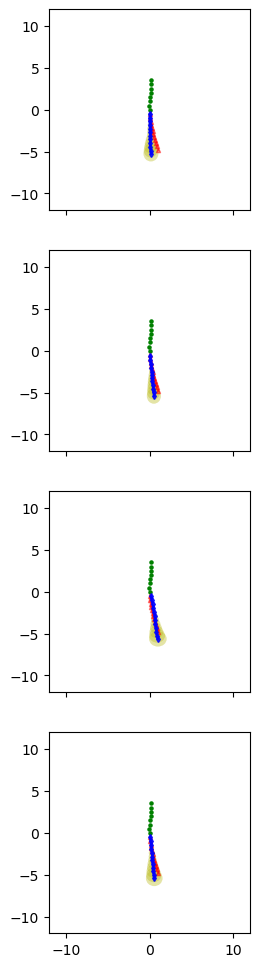

In [19]:

with open(os.path.join(PATH,'weights.pkl'), 'rb') as f:
    weights = pkl.load(f)

key = 3133
id_no = 0
plot_UQ (input_traj[key].detach().cpu().numpy(),
          output_traj[key].detach().cpu().numpy(), 
          mu_preds[key].detach().cpu().numpy(), 
          sigma_preds[key].detach().cpu().numpy(),
          weights,
          id_no = id_no)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


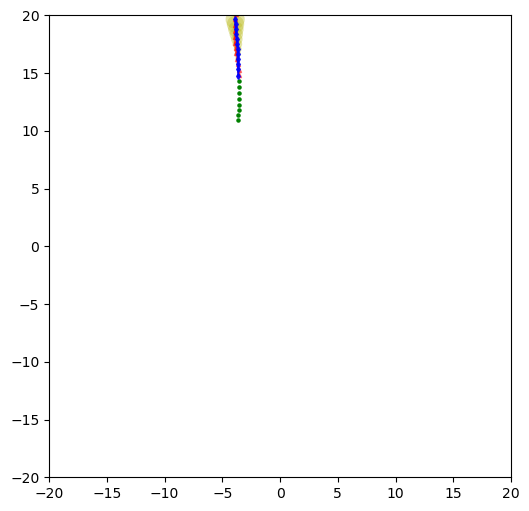

In [20]:
# Plot Animation:
## Animate the Trajectory for visualizing UQ:
import matplotlib.animation as animation


class animate_trajectory:
    def __init__(self, X_test, y_test, mus, sigmas, ground_cov, initial_pos, id_list, savefile):
        self.X_test = X_test
        self.y_test = y_test 
        self.mu_preds = mus
        self.sigmas = sigmas
        self.initial_pos = initial_pos
        self.ground_cov = ground_cov
        self.savefile = savefile
        num_fea = mus.shape[3]
        self.fig, self.ax = plt.subplots(figsize=(6, 6))
        
    # Define the initialization function to clear the plot
    def init_plot(self):
        self.ax.clear()
        self.ax.set_xlim([-20, 20])
        self.ax.set_ylim([-20, 20])
        self.ax.set_aspect('equal', adjustable='box')
        return self.ax,
    
    # Define the animation function
    def animate(self, id_no):
        self.ax.clear()
        self.ax.set_xlim([-20, 20])
        self.ax.set_ylim([-20, 20])
        self.ax.set_aspect('equal', adjustable='box')
        
        self.ax.scatter(self.X_test[id_no, :, 0] + self.initial_pos[id_no,0], self.X_test[id_no, :, 1] + self.initial_pos[id_no,1], color='g', marker='o', s=5, label='Input')
        self.ax.plot(self.y_test[id_no, :, 0] + self.initial_pos[id_no,0], self.y_test[id_no, :, 1] + self.initial_pos[id_no,1], color='r', alpha=0.5, marker='^', ms=3, label='Ground Truth')
        
        mu_ens = weighted_sum(weights, self.mu_preds)
        self.ax.plot(mu_ens[id_no, :, 0] + self.initial_pos[id_no,0], mu_ens[id_no, :, 1] + self.initial_pos[id_no,1], color='b', marker='d', alpha=0.85, ms=3, label='NN state Estimate')

        var_aleatoric = weighted_sum(weights, self.sigmas[:, :, :, :2])
        var_epistemic = weighted_sum(weights, self.mu_preds[:, :, :, :2] ** 2) - mu_ens[:, :, :2] ** 2
        var_ens = var_aleatoric + var_epistemic
        var_state_unc = weighted_sum(weights, self.mu_preds[:, :, :, 2:4])

        
        for pred in range(forward_pred):
            mean = np.squeeze(mu_ens[id_no, pred, :2]  + self.initial_pos[id_no,:])
            cov_pred = np.squeeze(np.squeeze(np.diag(var_ens[id_no, pred, :])))
            cov_state = np.squeeze(var_state_unc[id_no, pred, :2])
            cov_state = np.diag(np.squeeze(cov_state))
            

            lambda_tot, v_tot = np.linalg.eig(cov_pred)
            lambda_tot = np.sqrt(lambda_tot)
            lambda_ale, v_ale = np.linalg.eig(cov_state)
            lambda_ale = np.sqrt(lambda_ale)
            
            for j in range(1, 2):
                ell1 = Ellipse(xy=(mean[0], mean[1]),
                               width=(1 * lambda_ale[0]) * j * 2,
                               height=(1 * lambda_ale[1]) * j * 2,
                               angle=np.rad2deg(np.arccos((v_ale[0, 0]))),
                               color='none', lw=0.5)
                ell1.set_facecolor('tab:blue')
                ell1.set_alpha(0.2 / j)
                self.ax.add_artist(ell1)

                ell2 = Ellipse(xy=(mean[0], mean[1]),
                               width=(lambda_tot[0]) * j * 2,
                               height=(lambda_tot[1]) * j * 2,
                               angle=np.rad2deg(np.arccos((v_ale[0, 0]))),
                               color='none', linestyle='--', lw=0.25)
                ell2.set_facecolor('tab:olive')
                ell2.set_alpha(0.4 / j)
                self.ax.add_artist(ell2)

        # ax.legend()
        return self.ax,

    def animate_trajectories(self, id_list):
        self.id_list = id_list
        ani = animation.FuncAnimation(self.fig, self.animate, frames=self.id_list, init_func= self.init_plot, blit=False, repeat=False)
        anim_writer = animation.PillowWriter(fps=1)
        ani.save(self.savefile, writer=anim_writer)
        plt.show()


# Example usage
key = 3135
id_list = list(range(input_traj[key].shape[0]))  # Add more IDs as needed
plot_traj = animate_trajectory(input_traj[key].detach().cpu().numpy(),
          output_traj[key].detach().cpu().numpy(), 
          mu_preds[key].detach().cpu().numpy(), 
          sigma_preds[key].detach().cpu().numpy(),
          gaussian_test_traj.detach().cpu().numpy(),
          starting_pos[key].detach().cpu().numpy(),
          id_list,
          savefile = 'Trajectory_pred.gif')
plot_traj.animate_trajectories(id_list)

In [20]:
id_list[1]

1

In [97]:
x = np.random.rand(2,4)
[p,q,r,s] = x.T
print(p)
print(r)
p += 0.4 * r
print(p)

[0.96059694 0.8754203 ]
[0.51388736 0.96481618]
[1.16615188 1.26134677]


In [88]:
# Simulating a Trajectory Based on Predicted State:

# Define a function for simulating Pedestrian Trajectory:
def simulate_pedestrian(states):

    # Assuimg Constant velocity:
    x,y,u,v = states[:,0], states[:,1], states[:,2], states[:,3]
    x +=  dt * u 
    y +=  dt * v

    next_states = [x,y,u,v]
    return next_states
     


keys = np.random.choice(list(input_traj.keys()), size = 2, replace = False) # Randomly sample Keys
keys = [3135]
ensemble_predictions = {key: [] for key in keys}
print(keys) 
sim_Time = 12.0
dt = 0.4
N = int(sim_Time/dt)

for idx, model in enumerate(deep_ensemble.models):
    model_path = f"model_{idx}_parameters.pth"
    model.load_state_dict(torch.load(os.path.join(PATH, model_path)), strict=True)
    model.eval()

    # Temporarily storing predictions for this model:
    model_predictions = {}
    model_states = {}
    model_start_pos = {}
    for key in keys:
        value = input_traj[key]
        predictions = [] 
        states = torch.zeros(N,8,4).to(device)
        initial_pos = torch.zeros(N,2).to(device)
        for t in range(N):
            with torch.no_grad():
                if t < value.shape[0]:
                    prediction = model.predict(value[t,:,:].unsqueeze(0), target_len=forward_pred, device=device) 
                    predictions.append(prediction.squeeze())
                    states[t,:,:] = value[t,:,:].squeeze()
                    initial_pos[t,:] = starting_pos[key][t,:2]
                    print(states)
                else:
                    prediction = model.predict(states[t-1,:,:].unsqueeze(0), target_len=forward_pred, device=device)
                    states[t,:,:] = torch.concatenate((states[t-1,2:,:].unsqueeze(0), prediction[:,:2,:4]), dim =1) 
                    initial_pos[t, :] = prediction.squeeze()[0,:2] + initial_pos[t-1, :]
                    
                    # state_xy = prediction.squeeze()[2,:2]
                    # states[t,:,:2] -=  state_xy.unsqueeze(dim =0)
                    # value = torch.concatenate((value_xy, value)
                    predictions.append(prediction.squeeze())
                    # states.append(value.squeeze())
        
        # states  = torch.stack(states, dim = 0)
        # initial_pos = torch.stack(initial_pos, dim = 0)
        # initial_pos = initial_pos[:-1, :]
        # states  = states[:-1, :, :] 
        predictions = torch.stack(predictions, dim =0)    
        model_predictions[key] = predictions
        model_states[key] = states
        model_start_pos[key] = initial_pos
        
    # Append each key's prediction to the ensemble_predictions
    for key, preds in model_predictions.items():
        ensemble_predictions[key].append(preds)



# Transform  ensemble_predictions to numpy arrays: [3, n_traj, 12, 6]
mu_preds = {}
sigma_preds = {}
for key in ensemble_predictions:
    min_logvar, max_logvar = -4, 4
    ensemble_predictions[key] = torch.stack(ensemble_predictions[key], dim=0)
    preds = torch.cat((ensemble_predictions[key][:,:,:,:int(num_fea/2)], torch.exp(ensemble_predictions[key][:,:,:,int(num_fea/2):int(num_fea)])),3)
    sigmas = ensemble_predictions[key][:,:,:,int(num_fea):]
    sigmas = torch.clamp(sigmas, min=min_logvar, max=max_logvar)
    mu_preds[key] = torch.Tensor(preds)
    # mu_preds = denormalize_data(mu_preds, train_mean,  train_std)
    sigma_preds[key] = torch.Tensor(torch.exp(sigmas))


[3135]
tensor([[[-17.1630,  -1.3871,   0.0998,   0.8999],
         [-17.1231,  -1.0272,   0.0998,   0.8999],
         [-17.0831,  -0.6672,   0.0998,   0.8999],
         [-17.0432,  -0.3072,   0.0998,   0.8999],
         [-17.0033,   0.0528,   0.0998,   0.8999],
         [-16.9801,   0.4571,   0.0580,   1.0107],
         [-16.9680,   0.8909,   0.0302,   1.0845],
         [-16.9559,   1.3246,   0.0302,   1.0845]],

        [[  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000, 

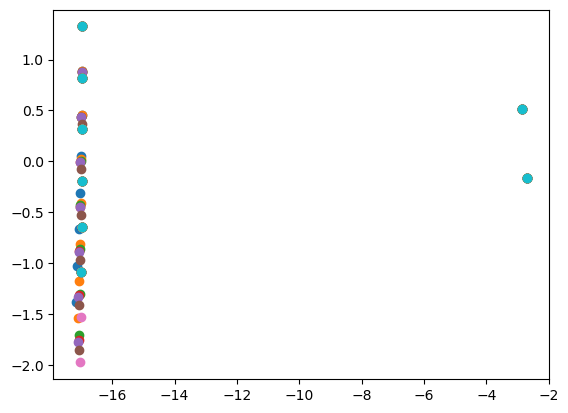

In [87]:
for i in range(model_states[key].shape[0]):
    if i < 8:
        x = model_states[key][i,:,0].detach().cpu().numpy() 
        y = model_states[key][i,:,1].detach().cpu().numpy() 

    plt.scatter(x,y)
ax = plt.gca()
# ax.set_xlim([-6, -2])
plt.show()

In [41]:
model_states[key].shape

torch.Size([30, 8, 4])

In [24]:
# Plot Animation:
## Animate the Trajectory for visualizing UQ:
import matplotlib.animation as animation


class animate_trajectory_pred():
    def __init__(self, X_test, y_test, mus, sigmas, ground_cov, initial_pos, id_list, savefile):
        self.X_test = X_test
        self.y_test = y_test 
        self.mu_preds = mus
        self.sigmas = sigmas
        self.initial_pos = initial_pos
        self.ground_cov = ground_cov
        self.savefile = savefile
        num_fea = mus.shape[3]
        self.fig, self.ax = plt.subplots(figsize=(6, 6))
        
    # Define the initialization function to clear the plot
    def init_plot(self):
        self.ax.clear()
        self.ax.set_xlim([-20, 20])
        self.ax.set_ylim([-20, 20])
        self.ax.set_aspect('equal', adjustable='box')
        return self.ax,
    
    # Define the animation function
    def animate(self, id_no):
        self.ax.clear()
        self.ax.set_xlim([-20, 20])
        self.ax.set_ylim([-20, 20])
        self.ax.set_aspect('equal', adjustable='box')
        
        self.ax.scatter(self.X_test[id_no, :, 0] + self.initial_pos[id_no,0], self.X_test[id_no, :, 1] + self.initial_pos[id_no,1], color='g', marker='o', s=5, label='Input')
        # self.ax.plot(self.y_test[id_no, :, 0] + self.initial_pos[id_no,0], self.y_test[id_no, :, 1] + self.initial_pos[id_no,1], color='r', alpha=0.5, marker='^', ms=3, label='Ground Truth')
        
        mu_ens = weighted_sum(weights, self.mu_preds)
        self.ax.plot(mu_ens[id_no, :, 0] + self.initial_pos[id_no,0], mu_ens[id_no, :, 1] + self.initial_pos[id_no,1], color='b', marker='d', alpha=0.85, ms=3, label='NN state Estimate')

        var_aleatoric = weighted_sum(weights, self.sigmas[:, :, :, :2])
        var_epistemic = weighted_sum(weights, self.mu_preds[:, :, :, :2] ** 2) - mu_ens[:, :, :2] ** 2
        var_ens = var_aleatoric + var_epistemic
        var_state_unc = weighted_sum(weights, self.mu_preds[:, :, :, 2:4])
        
        for pred in range(forward_pred):
            mean = np.squeeze(mu_ens[id_no, pred, :2]  + self.initial_pos[id_no,:])
            cov_pred = np.squeeze(np.squeeze(np.diag(var_ens[id_no, pred, :])))
            cov_state = np.squeeze(var_state_unc[id_no, pred, :2])
            cov_state = np.diag(np.squeeze(cov_state))
            
            lambda_tot, v_tot = np.linalg.eig(cov_pred)
            lambda_tot = np.sqrt(lambda_tot)
            lambda_ale, v_ale = np.linalg.eig(cov_state)
            lambda_ale = np.sqrt(lambda_ale)
            
            for j in range(1, 2):
                ell1 = Ellipse(xy=(mean[0], mean[1]),
                               width=(1 * lambda_ale[0]) * j * 2,
                               height=(1 * lambda_ale[1]) * j * 2,
                               angle=np.rad2deg(np.arccos((v_ale[0, 0]))),
                               color='none', lw=0.5)
                ell1.set_facecolor('tab:blue')
                ell1.set_alpha(0.2 / j)
                self.ax.add_artist(ell1)

                ell2 = Ellipse(xy=(mean[0], mean[1]),
                               width=(lambda_tot[0]) * j * 2,
                               height=(lambda_tot[1]) * j * 2,
                               angle=np.rad2deg(np.arccos((v_ale[0, 0]))),
                               color='none', linestyle='--', lw=0.25)
                ell2.set_facecolor('tab:olive')
                ell2.set_alpha(0.4 / j)
                self.ax.add_artist(ell2)

        # ax.legend()
        return self.ax,

    def animate_trajectories(self, id_list):
        self.id_list = id_list
        # max_frames = max([len(self.X_test[id_no]) for id_no in id_list])
        ani = animation.FuncAnimation(self.fig, self.animate, frames=id_list, init_func= self.init_plot, blit=False, repeat=False)
        anim_writer = animation.PillowWriter(fps=1)
        ani.save(self.savefile, writer=anim_writer)
        plt.show()


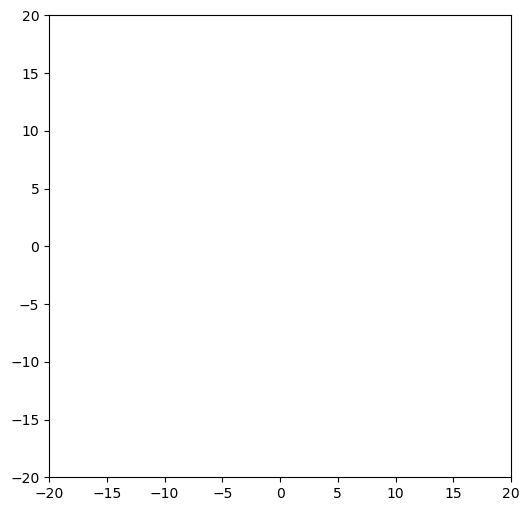

In [25]:
key = keys[0]
id_list = list(range(model_states[key].shape[0])) # Add more IDs as needed
plot_traj = animate_trajectory_pred(model_states[key].detach().cpu().numpy(),
          output_traj[key].detach().cpu().numpy(), 
          mu_preds[key].detach().cpu().numpy(), 
          sigma_preds[key].detach().cpu().numpy(),
          gaussian_test_traj.detach().cpu().numpy(),
          model_start_pos[key].detach().cpu().numpy(),
          id_list,
          savefile='Trajectory_pred.gif')
plot_traj.animate_trajectories(id_list)

In [3]:
import numpy as np
A = np.array([1,2])
print(A.shape)
np.diag(A)

(2,)


array([[1, 0],
       [0, 2]])